# Fig 5: Analysis of mean-squared displacement

Here we generate the data for figure 5, which compares the mean-squared displacement between the OU model to a model with division noise

## Setup and Load data

In [2]:
using CSV
using DataFrames
using Distributions
using StatsBase
using PythonPlot
using Random
using Tables
using DifferentialEquations
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools
cd(dirname(@__FILE__))

### Load experimental data

In [3]:
# raw data
data_raw = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);

data_gp = CSV.read("./../output/gp/data/preds.csv",DataFrame)
lineages = unique(data_gp.lineage);
lengths = vcat([
    length(
        unique(data_gp[data_gp.lineage .== lineages[i],:position])
        ) .*
    ones(
        length(
            data_gp[data_gp.lineage .== lineages[i],:time]
            )
        ) 
    for i in eachindex(lineages)]...)
data_gp[:,:length] = lengths
data_gp = data_gp[data_gp.length .>=9,:]
lineages = unique(data_gp.lineage);


### Load simulations

In [12]:
sims = CSV.read("./../output/sims_OUfit.csv",DataFrame);
sims_gp = CSV.read("./../output/gp/sims/preds.csv",DataFrame);
#τ_range = unique(sims.τ);
ϕ_range = unique(sims.ϕ);
sort!(sims_gp,:lineage)

Row,matern32notrend_flucs,matern32notrend_flucs_var,matern32notrend_flucs_x,matern32notrend_flucs_x_var,time,position,linear,lineage,age
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.104409,NaN,0.00122794,1.65923e-6,0.0,0.0,-0.104409,1.0,0.0
2,0.104723,NaN,0.00345335,8.23844e-7,0.1,0.0,-0.096624,1.0,0.1
3,0.104935,1.6459e-12,-0.00342392,8.03732e-7,0.2,0.0,-0.0888389,1.0,0.2
4,0.104188,NaN,-0.00943618,7.8656e-7,0.3,0.0,-0.0810538,1.0,0.3
5,0.103261,NaN,-0.00746979,8.22849e-7,0.4,0.0,-0.0732687,1.0,0.4
6,0.102545,1.13056e-12,-0.00549207,8.20609e-7,0.5,0.0,-0.0654836,1.0,0.5
7,0.102027,NaN,-0.00615659,8.18329e-7,0.6,0.0,-0.0576985,1.0,0.6
8,0.101223,1.2971e-12,-0.00862095,8.18523e-7,0.7,0.0,-0.0499134,1.0,0.7
9,0.100413,NaN,-0.00799977,7.96851e-7,0.8,0.0,-0.0421283,1.0,0.8


In [14]:
function map_lineage_col!(d1,d2,name)
    d2[:,name] = vcat(
    [
        d1[d1.lineage .==l,name][1]*ones(
            length(
                d2[d2.lineage .==l,:time]
                )
            ) 
    for l in unique(d2.lineage)
    ]
    ...);
end

#map_lineage_col!(sims,sims_gp,:τ);
map_lineage_col!(sims,sims_gp,:lineage_original);
map_lineage_col!(sims,sims_gp,:ϕ);
#sims_gp[:,:ϕ] = 1 .-sims_gp.model 

sims_gp;
CSV.write("./../output/gp/preds_fig5.csv",sims_gp)

"./../output/gp/preds_fig5.csv"

## Compare GP to sims in division noise model

Here we check visually that the Gaussian process procedure perserves the structure of growth rates in the division noise model 

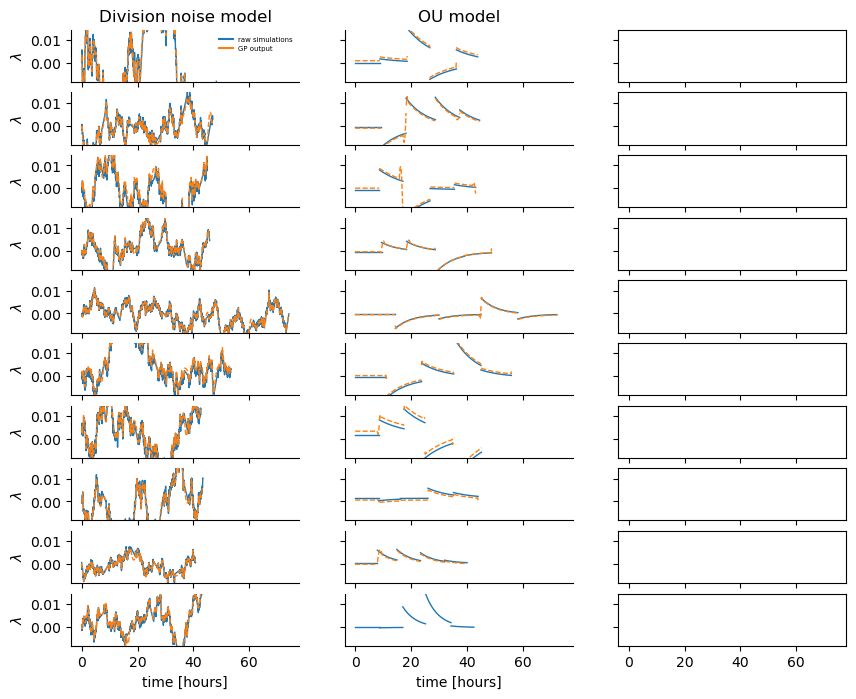

In [17]:
k = 2
lw = 1


fig, axs= subplots(figsize=(10,8),nrows=length(lineages),ncols=3,sharex=true,sharey=true)

for k in eachindex(lineages)

    # ---------------------------------------------------------------------------------
    # Division noise model

    ax = axs[k-1,0]
    d = sims[sims.lineage_original .== lineages[k],:]
    #d = d[d.τ .== τ_range[1],:]
    d = d[d.ϕ .== ϕ_range[1],:]
    d = d[d.replicate .==1,:];
    dgp = sims_gp[sims_gp.lineage.== d.lineage[k],:];

    z = d.λ .- mean(d.λ)
    for p in unique(d.position)[1:5]
        ax.plot(d[d.position .== p,:].time .- d.time[1],z[d.position .==p],"C0",lw=lw)
        ax.plot(dgp[dgp.position .== p,:].time,dgp[dgp.position .== p,:].matern32notrend_flucs_x,"C1--",lw=lw)
    end
    ax.set_ylim([min(z...),max(z...)])
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.set_ylabel(L"$\lambda$")
    ax.set_title("")

    # ---------------------------------------------------------------------------------
    # OU model 

    ax = axs[k-1,1]
    d = sims[sims.lineage_original .== lineages[k],:]
    #d = d[d.τ .== τ_range[1],:]
    d = d[d.ϕ .== ϕ_range[2],:]
    d = d[d.replicate .==1,:];
    dgp = sims_gp[sims_gp.lineage.== d.lineage[k],:];

    z = d.λ .- mean(d.λ)
    for p in unique(d.position)[1:5]
        ax.plot(d[d.position .== p,:].time .- d.time[1],z[d.position .==p],"C0",lw=lw)
        ax.plot(dgp[dgp.position .== p,:].time,dgp[dgp.position .== p,:].matern32notrend_flucs_x,"C1--",lw=lw)
    end
    ax.set_ylim([min(z...),max(z...)])
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)


    # ---------------------------------------------------------------------------------
    # OU model 

    # ax = axs[k-1,2]
    # d = sims[sims.lineage_original .== lineages[k],:]
    # #d = d[d.τ .== τ_range[1],:]
    # d = d[d.ϕ .== ϕ_range[3],:]
    # d = d[d.replicate .==1,:];
    # dgp = sims_gp[sims_gp.lineage.== d.lineage[k],:];

    # z = d.λ .- mean(d.λ)
    # for p in unique(d.position)[1:5]
    #     ax.plot(d[d.position .== p,:].time .- d.time[1],z[d.position .==p],"C0",lw=lw)
    #     ax.plot(dgp[dgp.position .== p,:].time,dgp[dgp.position .== p,:].matern32notrend_flucs_x,"C1--",lw=lw)
    # end
    # #ax.set_ylim([min(z...),max(z...)])
    # ax.spines["top"].set_visible(false)
    # ax.spines["right"].set_visible(false)
end

axs[0,0].set_title("Division noise model")
axs[0,1].set_title("OU model")
axs[0,0].plot([0],[0],"C0-",label="raw simulations")
axs[0,0].plot([0],[0],"C1-",label="GP output")
axs[-1,0].set_xlabel("time [hours]")
axs[-1,1].set_xlabel("time [hours]")
axs[0,0].legend(frameon=false,fontsize=5)
savefig("./../figures/sims_gp-vs-raw.pdf")

fig

## Mean-squared displacement comparison 

### MSD Setup 

In [18]:
function MSD(x,max_steps)
    n = length(x)
    msd = zeros(max_steps)
    for i in 1:max_steps 
        msd[i] = mean((x[1:end-i] .- x[i+1:end]).^2)
    end
    return msd
end

function make_msd_dataframe(df,steps,col)
    msd_all = MSD(df[:,col],steps)
    msd_within = mean(hcat([MSD(df[df.position .==p,col],steps) for p in unique(df.position)]...),dims=2)[:,1]
    dt = mean(diff(df[:,:time]))
    times = collect(0:1:(steps-1))*dt
    ratio = (msd_within ) ./ (msd_all)
    dict = Dict(:msd_all => msd_all,:msd_within => msd_within,:lag => times,:ratio => ratio)
    msf_df = DataFrame(dict)
end


function apply_msd_to_groups(df, steps, col, group_col)
    # Define a wrapper function to pass to combine
    function msd_per_group(sub_df)
        return make_msd_dataframe(sub_df, steps, col)
    end

    # Use combine to apply the function to each group and concatenate the results
    combined_df = combine(groupby(df, group_col), msd_per_group)

    return combined_df
end


apply_msd_to_groups (generic function with 1 method)

In [20]:

steps = 100
msd_sims = apply_msd_to_groups(sims_gp, steps,"matern32notrend_flucs_x", :lineage);
msd_data = apply_msd_to_groups(data_gp, steps,"matern32_flucs_x", :lineage);

# add original information to msd_sims
lineage_map = l -> Array(sims[sims.lineage .== l,[:ϕ,:lineage_original]])[1,:]
msd_sims = hcat(msd_sims,DataFrame(hcat(lineage_map.(msd_sims.lineage)...)',[:ϕ,:lineage_original]))
CSV.write("./../output/msd_sims.csv",msd_sims)
CSV.write("./../output/msd_data.csv",msd_data)


"./../output/msd_data.csv"

### Make MSD Figure

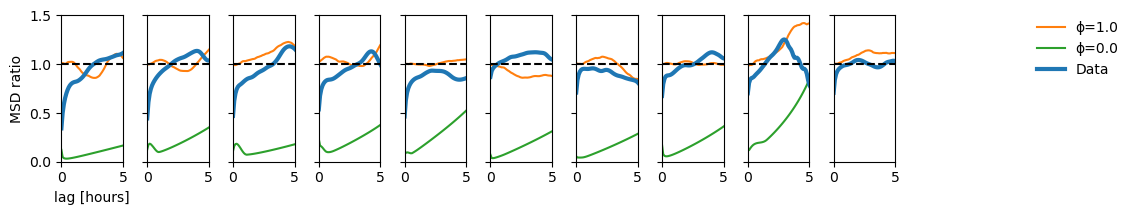

In [21]:
fig, axs= subplots(figsize=(9,2),ncols=length(lineages),nrows=1,sharex=true,sharey=true)
for k in eachindex(lineages)

    ax = axs[k-1]

    # first get the raw simulation dataframe we want 
    d = sims[sims.lineage_original .== lineages[k],:]
    #d = d[d.τ .== τ_range[1],:]
    d = d[d.replicate .==1,:];
    
    
    # ----------------------------------------------------------------------
    for i in eachindex(ϕ_range)
        dm = msd_sims[msd_sims.lineage.== d[d.ϕ .== ϕ_range[i],:].lineage[1],:];
        # plot MSD ratio 
        ax.plot(dm.lag,dm.ratio,"C"*string(i)*"-",label="ϕ="*string(ϕ_range[i]))
    end



    # ----------------------------------------------------------------------
    # DATA
    dd = data_gp[data_gp.lineage.== lineages[k],:]
    msd_df = make_msd_dataframe(dd,steps,"matern32_flucs_x") 

    # plot MSD ratio 
    ax.plot(msd_df.lag,msd_df.ratio,"C0-",label="Data",lw=3)



    # dd = data_gp[data_gp.lineage.== lineages[k],:]
    # m1 = MSD(dd.matern32_flucs_x,steps)
    # m2 = mean(hcat([MSD(dd[dd.position .== p,:].matern32_flucs_x,steps) for p in unique(dd.position)]...),dims=2)[:,1]
    # r = m1 ./ m2
    # ax.plot(r,"C5-",label="data")


    

    #ax = axs[k-1]
    # d = sims[sims.lineage_original .== lineages[k],:]
    # d = d[d.τ .== τ_range[1],:]
    # d = d[d.model .== 0,:]
    # d = d[d.replicate .==1,:];
    # dgp = sims_gp[sims_gp.lineage.== d.lineage[k],:];

    # ------------------------------------------------------------------------------------
    # dgp = sims_gp[sims_gp.lineage.== d.lineage[k],:];
    # m1 = MSD(dgp.matern32notrend_flucs_x,steps)
    # m2 = mean(hcat([MSD(dgp[dgp.position .== p,:].matern32notrend_flucs_x,steps) for p in unique(dgp.position)]...),dims=2)[:,1]
    # r = m1 ./ m2
    # ax.plot(r,"C4--",label="OU")
    ax.plot(msd_df.lag,ones(steps),"k--")
    ax.set_xlim([0,5])

end
tight_layout()
axs[-1].legend(frameon=false,bbox_to_anchor=(3.1, 1.05))
axs[0].set_xlabel("lag [hours]")
axs[0].set_ylabel("MSD ratio")
axs[0].set_ylim([0,1.5])
fig